In [121]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [122]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

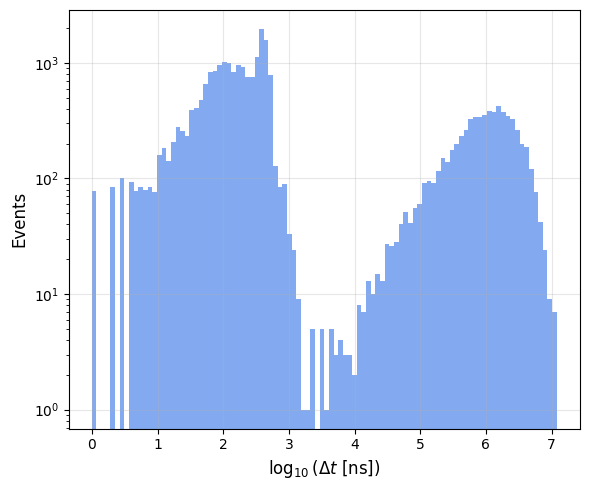

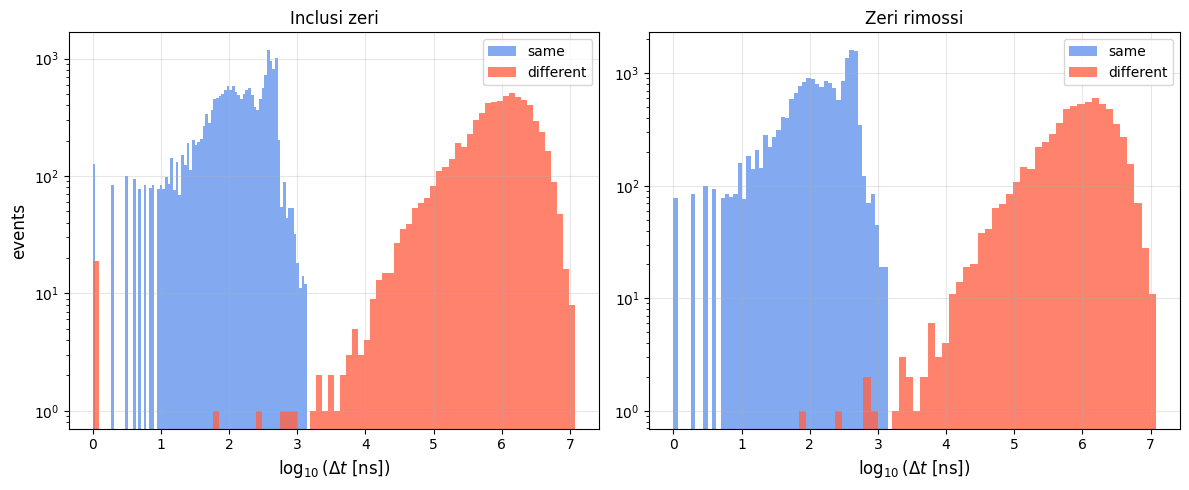

In [123]:
#calcolo differenze di tempi
delta_t=np.diff(df_all_sorted["TIME_ABS"])
delta_ts = delta_t[delta_t > 0] #uso maschere e cambio
#print(len(delta_t), len(delta_ts))
#print(delta_t[delta_t <= 0])

# Crea l'istogramma tutti gli eventi
#usando le maschere, non suddivido tra eventi diversi e stesso evento
#escludo gli zeri
plt.figure(figsize=(6, 5))
plt.hist(np.log10(delta_ts), bins=100, color='cornflowerblue', alpha=0.8)
plt.yscale('log')
plt.xlabel(r'$\log_{10}(\Delta t\ \mathrm{[ns]})$', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.tight_layout()
plt.grid(alpha=0.3)
#plt.show()


#ordino eventi con il for e suddivisione same e different
df_all_sorted=df_all.sort_values(["MCRUN","EVENT","TIME_ABS"]).reset_index(drop=True)
delta_t_same = []
delta_t_diff = []

for i in range(1, len(df_all_sorted)):
    if ((df_all_sorted.loc[i, "MCRUN"]==df_all_sorted.loc[i-1, "MCRUN"])&
        (df_all_sorted.loc[i, "EVENT"] ==df_all_sorted.loc[i-1, "EVENT"])):
        delta_t_same.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
    else:
        delta_t_diff.append(df_all_sorted.loc[i, "TIME_ABS"]-
                            df_all_sorted.loc[i-1, "TIME_ABS"])
delta_t_same = np.array(delta_t_same)
delta_t_diff = np.array(delta_t_diff)
delta_t_same_safe = np.where(delta_t_same > 0, delta_t_same, 1)
delta_t_diff_safe = np.where(delta_t_diff > 0, delta_t_diff, 1)
#suddivido tra stesso evento e evento separato sostituendo i deltat con 1
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(np.log10(delta_t_same_safe), bins=80, color='cornflowerblue',
             alpha=0.8, label='same')
ax[0].hist(np.log10(delta_t_diff_safe), bins=80, color='tomato',
             alpha=0.8, label='different')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\log_{10}(\Delta t\ \mathrm{[ns]})$', fontsize=12)
ax[0].set_ylabel('events', fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()
ax[0].set_title("Inclusi zeri")

# Secondo plot (zeri rimossi)
delta_t_same_saf0 = delta_t_same[delta_t_same > 0]
delta_t_diff_saf0 = delta_t_diff[delta_t_diff > 0]

ax[1].hist(np.log10(delta_t_same_saf0), bins=50, color='cornflowerblue',
             alpha=0.8, label='same')
ax[1].hist(np.log10(delta_t_diff_saf0), bins=50, color='tomato',
             alpha=0.8, label='different')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log_{10}(\Delta t\ \mathrm{[ns]})$', fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()
ax[1].set_title("Zeri rimossi")

plt.tight_layout()
plt.show()

mc=266033, ev=3109


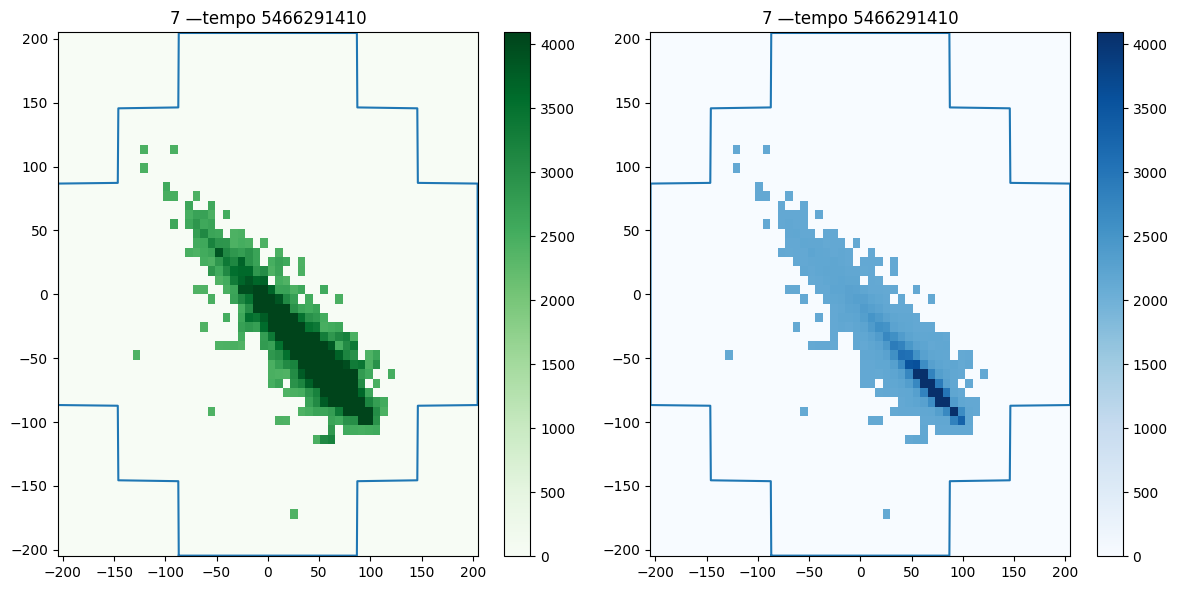

mc=266033, ev=3109


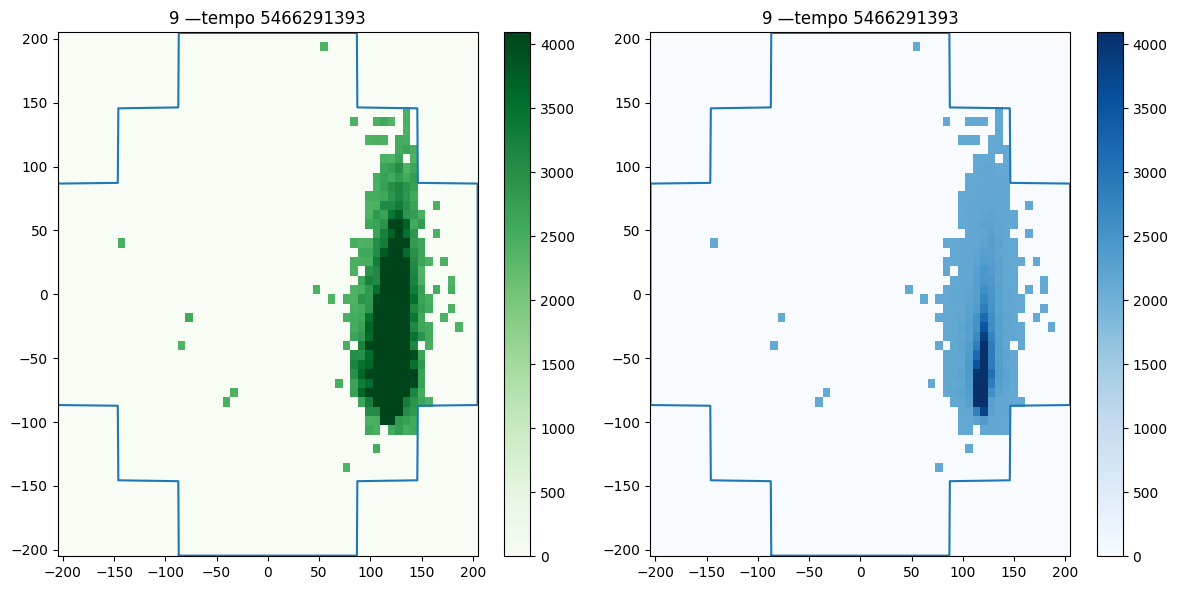

mc=266370, ev=5710


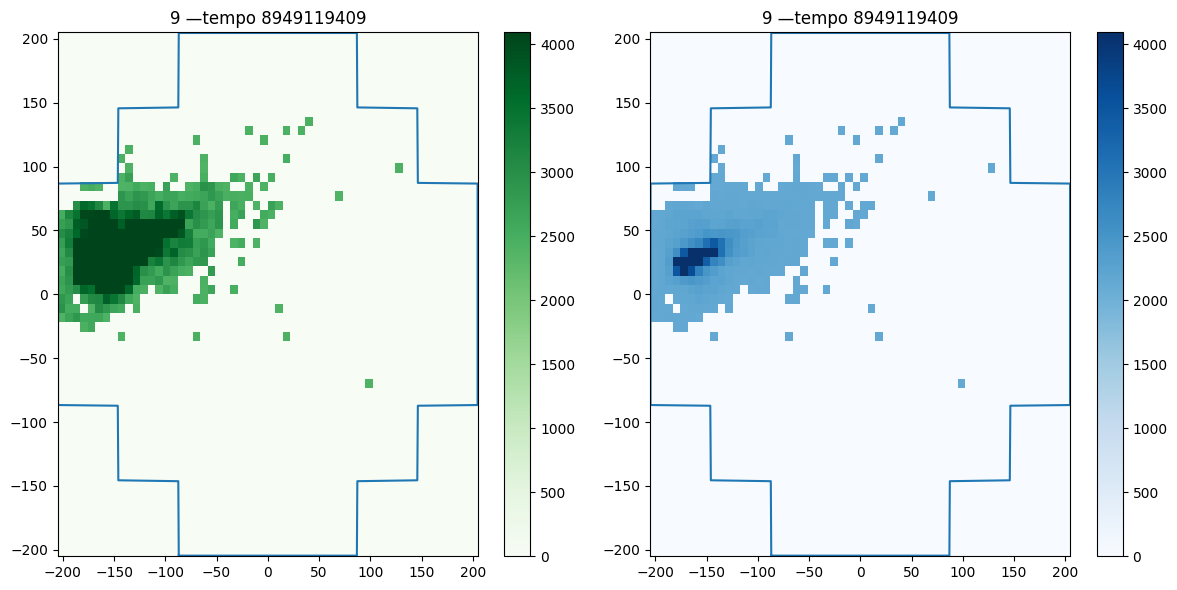

In [124]:

xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

event_energies = df_all_sorted['HG'].apply(np.sum)
top_indices = np.argsort(event_energies)[-3:]
#i 3 eventi più energetici in assoluto tra tutti i file
for iev in top_indices:
    print(f"mc={df_all_sorted['MCRUN'][iev]}, ev={df_all_sorted['EVENT'][iev]}")
    
    # ciclo sui primi eventi piu energetici
    #for iev in range(10):
    hgev = np.array(df_all_sorted['HG'])[iev]
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
            # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()

#print(np.shape(top_indices))
#print(event_energies)

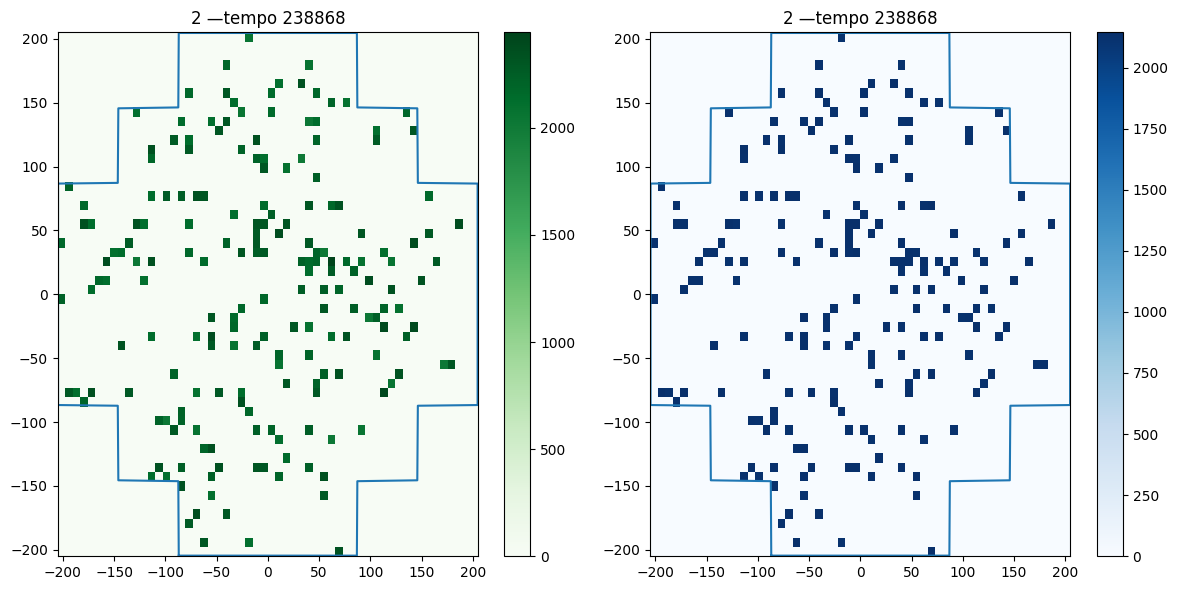

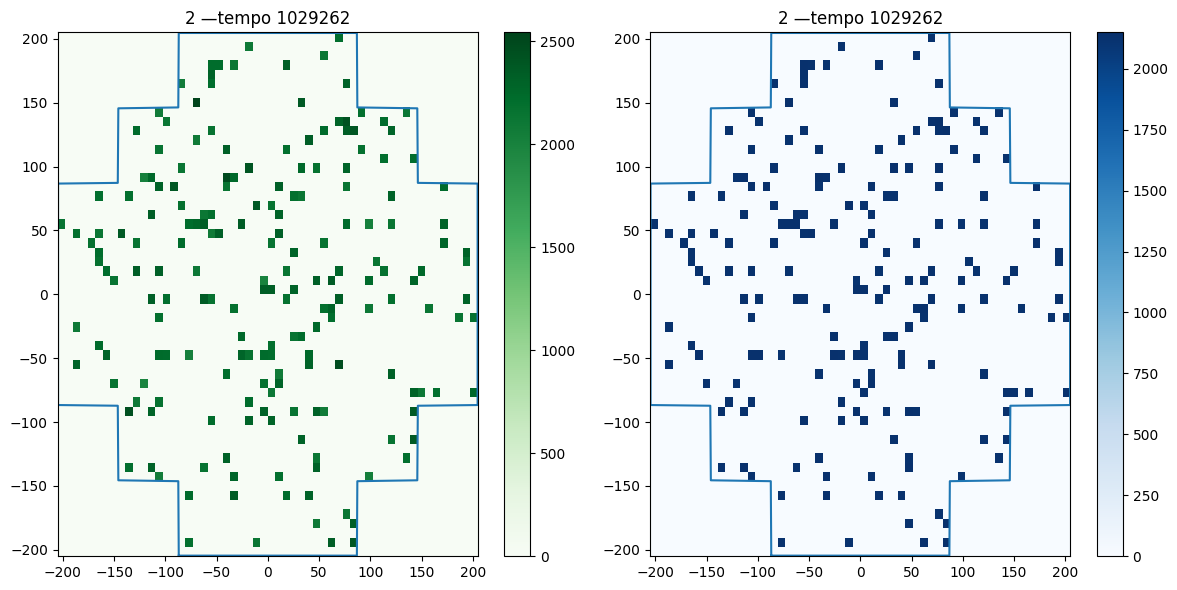

In [125]:
#eventi casuali
for iev in range(2):
    
    # ciclo sui primi eventi
    #for iev in range(10):
    hgev = np.array(df_all_sorted['HG'])[iev]
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
    pxmask =(hgev>100) & (ttpev < 255)

            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()


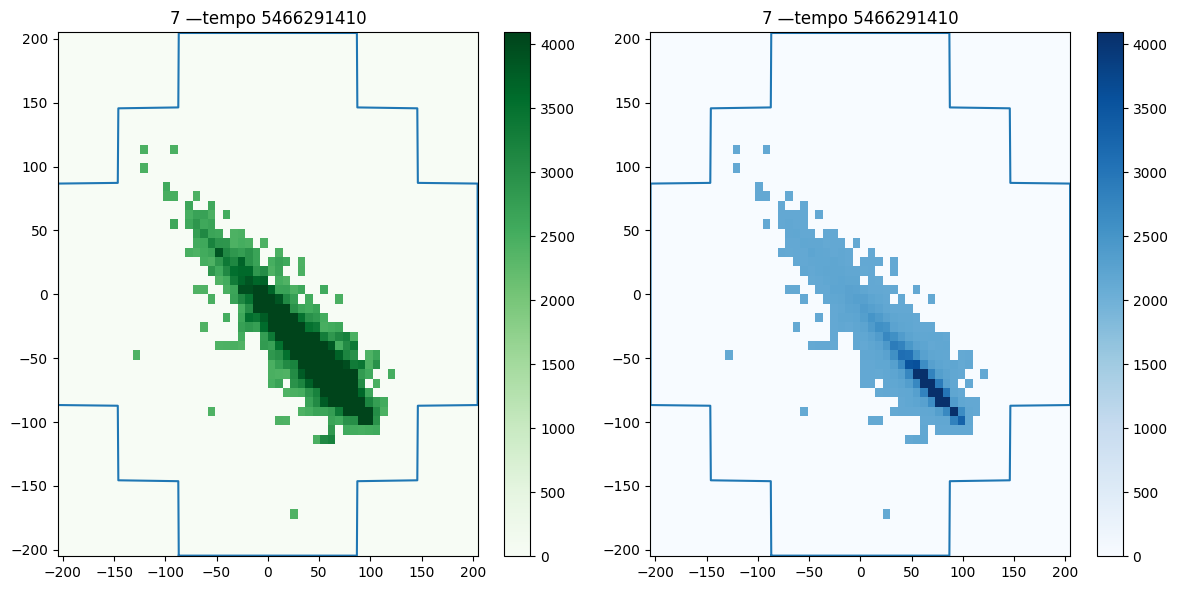

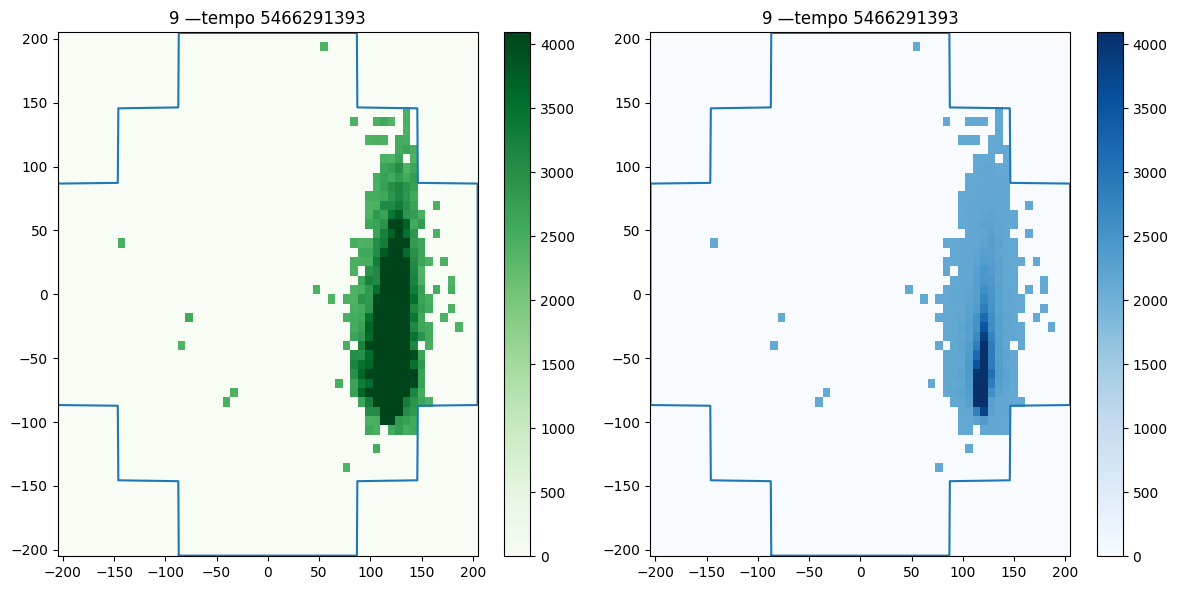

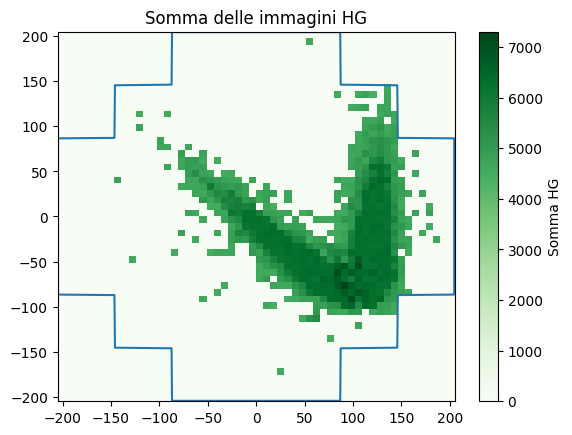

In [126]:
weights = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)



for iev in top_indices[0:2]:
    hgev = np.array(df_all_sorted['HG'])[iev]
    weights += hgev  # somma elemento per elemento
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")

    plt.show()
weights=np.array(weights)
plt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=weights[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
plt.plot(xfp, yfp)
plt.colorbar(label='Somma HG')
plt.title('Somma delle immagini HG')
plt.show()


In [127]:
#cerco un modo di selezionare con gli indici gli eventi che avvengono allo stesso tempo
delta=1e3 #ns

'''
groups = []
current_group = [0]
delta=1e7 #ns
for i in range(1, len(df_all_sorted)):
    if abs(df_all_sorted.loc[i,'TIME_ABS']-df_all_sorted.loc[i - 1, 'TIME_ABS'])<= delta:
        current_group.append(i)
    else:
        if len(current_group) > 1:
            groups.append(current_group)
        current_group = [i]
'''

# Calcolo la differenza tra tempi consecutivi
dt = df_all_sorted['TIME_ABS'].diff().fillna(0)

# Identifico dove la differenza supera delta → inizio nuovo gruppo
group_id = (dt > delta).cumsum()

# Raggruppo per group_id
groups = [list(group.index) for _, group in df_all_sorted.groupby(group_id) if len(group) > 1]
# Mostriamo i risultati
for g in groups:
    print(f"Eventi entro {delta}:\n indici {g},\n tempi {[df_all_sorted.loc[i, 'TIME_ABS'] for i in g]}")
time_min = df_all_sorted['TIME_ABS'].min()
time_max = df_all_sorted['TIME_ABS'].max()
time_span = time_max - time_min

print(f"Tempo minimo: {time_min}")
print(f"Tempo massimo: {time_max}")

print(f"Intervallo totale: {time_span} ns \n divisione={time_span/delta}")


Eventi entro 1000.0:
 indici [4, 5, 6, 7, 8, 9, 10, 11],
 tempi [3678725, 3679036, 3679123, 3679447, 3679515, 3679547, 3679960, 3680005]
Eventi entro 1000.0:
 indici [13, 14, 15, 16, 17],
 tempi [4254169, 4254226, 4254620, 4254651, 4255150]
Eventi entro 1000.0:
 indici [22, 23],
 tempi [11875502, 11876012]
Eventi entro 1000.0:
 indici [28, 29],
 tempi [25222687, 25223097]
Eventi entro 1000.0:
 indici [32, 33, 34],
 tempi [28729559, 28729597, 28730106]
Eventi entro 1000.0:
 indici [36, 37, 38, 39, 40, 41, 42, 43, 44],
 tempi [28859025, 28859186, 28859344, 28859426, 28859771, 28859803, 28859815, 28860261, 28860277]
Eventi entro 1000.0:
 indici [45, 46, 47, 48, 49, 50],
 tempi [31623544, 31623658, 31623933, 31624023, 31624454, 31624512]
Eventi entro 1000.0:
 indici [51, 52, 53, 54, 55, 56, 57],
 tempi [32680673, 32680807, 32681022, 32681076, 32681466, 32681490, 32681974]
Eventi entro 1000.0:
 indici [59, 60, 61, 62, 63, 64, 65, 66, 67],
 tempi [35023635, 35023796, 35023969, 35024058, 3502

In [128]:

'''
#ordino per differenze temporali consecutive 
event_energies = df_all_sorted['HG'].apply(np.sum).to_numpy()
times = df_all_sorted['TIME_ABS'].to_numpy()
#per avere stesse dimensioni mette un valore -inf 
diffs = np.argsort(np.diff(times, prepend=-np.inf))
min_dt = np.minimum

selected_indices = diffs[:10]
top_indices = selected_indices[np.argsort(event_energies[selected_indices])[-3:]]
'''

"\n#ordino per differenze temporali consecutive \nevent_energies = df_all_sorted['HG'].apply(np.sum).to_numpy()\ntimes = df_all_sorted['TIME_ABS'].to_numpy()\n#per avere stesse dimensioni mette un valore -inf \ndiffs = np.argsort(np.diff(times, prepend=-np.inf))\nmin_dt = np.minimum\n\nselected_indices = diffs[:10]\ntop_indices = selected_indices[np.argsort(event_energies[selected_indices])[-3:]]\n"

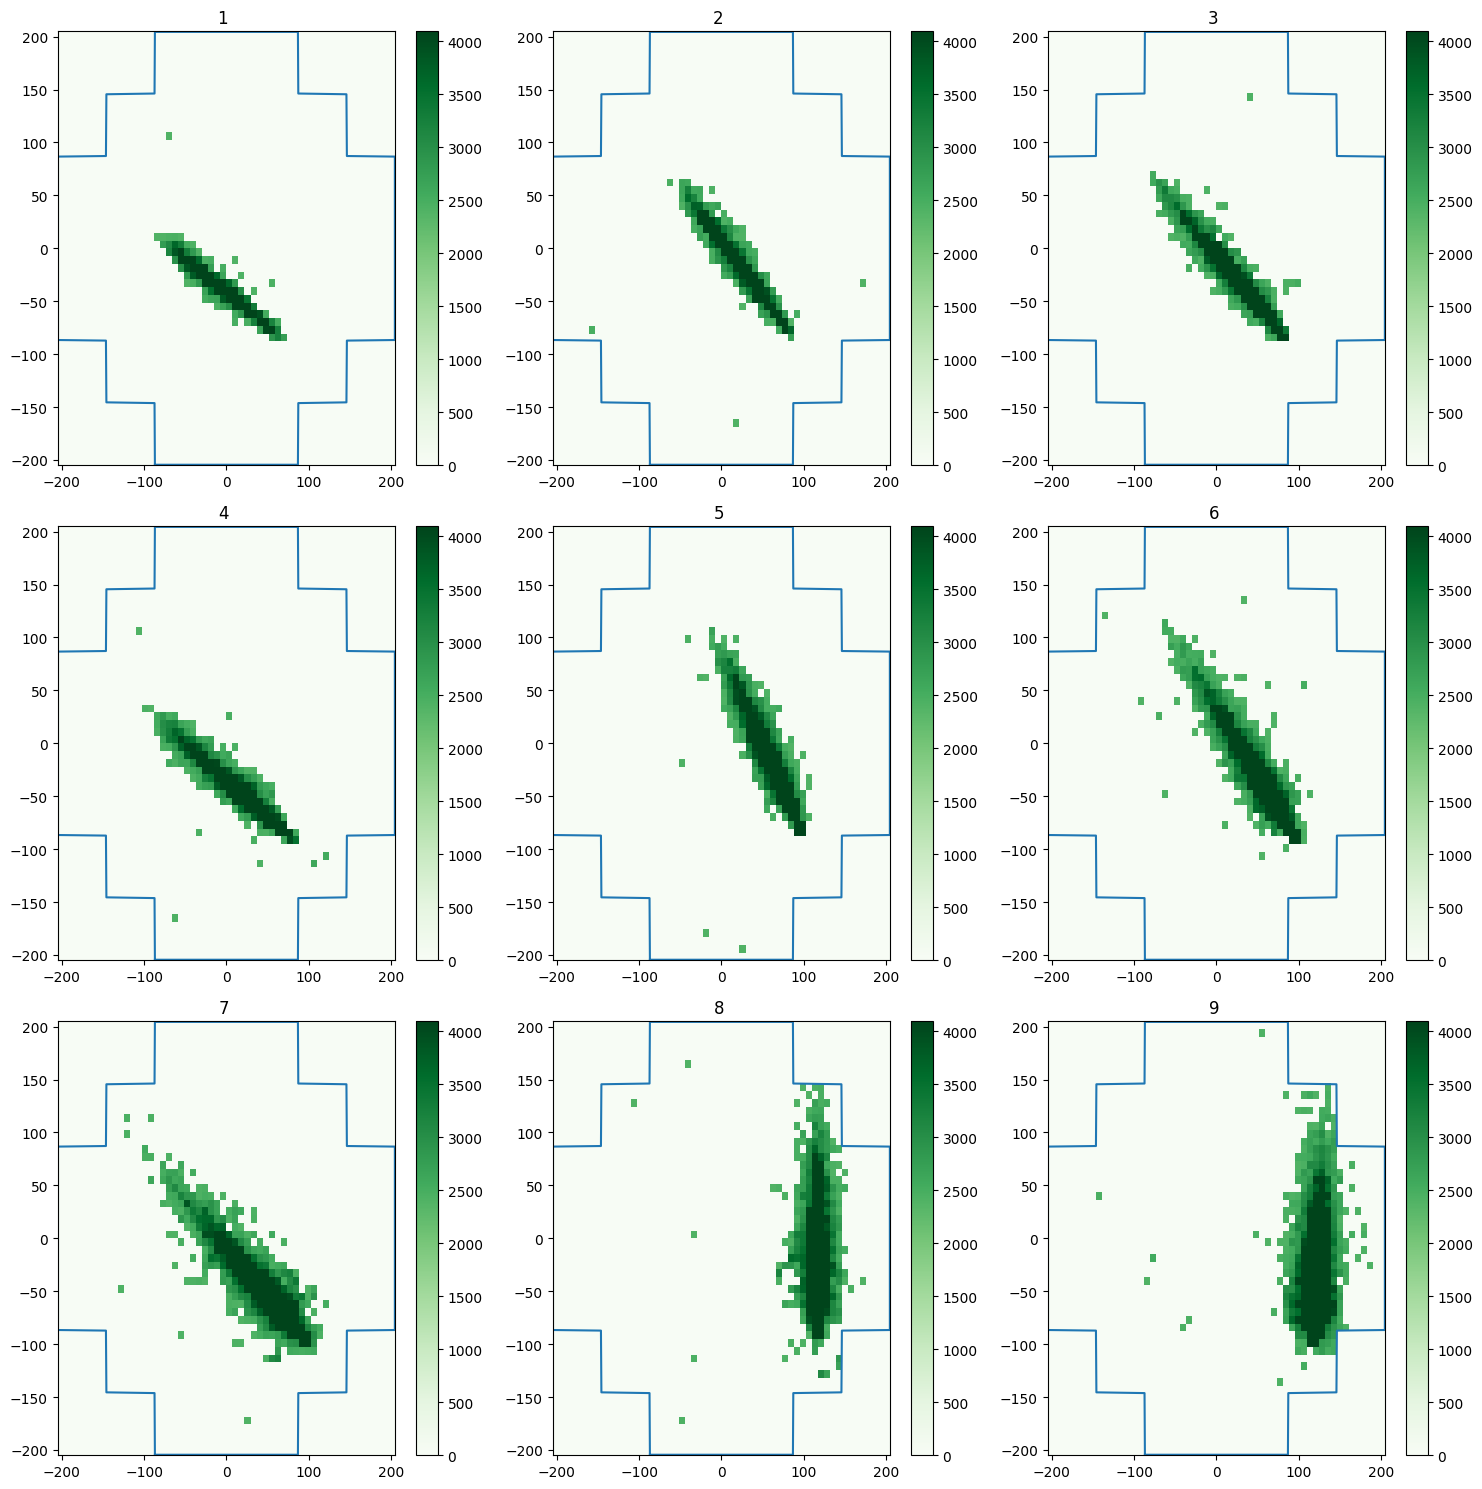

"\nplt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),\n                          weights=peso[mask_tot].flatten(),range=((-205, 205), (-205, 205)),\n                          bins=7*8, cmap='Greens')\nplt.plot(xfp, yfp)\nplt.colorbar(label='Somma HG')\nplt.title('Somma delle immagini HG')\nplt.show()\n"

In [152]:
#stampo lo stesso evento, che già conosco
target=3109
target_mc =266033
df_target= df_all_sorted[
    (df_all_sorted['EVENT'] == target) &
    (df_all_sorted['MCRUN'] == target_mc)
]
df_target=df_target.sort_values(by='TEL_ID')
# peso = np.zeros_like(np.array(df_all_sorted['HG'])[0])
mask_tot = np.zeros((37, 64), dtype=bool)


fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    peso += hgev  # somma elemento per elemento

    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    mask_tot |= pxmask      # somma logica (OR)
            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
       
        # plot
    row = itel // 3  # calcola riga
    col = itel % 3   # calcola colonna
    ax = axes[row, col]
    hl = ax.hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    '''
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    '''
    fig.colorbar(hl[3], ax=ax)
    ax.plot(xfp, yfp)
    ax.set_title(f"{df_target['TEL_ID'].iloc[itel]} ")

plt.show()
'''
plt.hist2d(x_pix[mask_tot].flatten(),y_pix[mask_tot].flatten(),
                          weights=peso[mask_tot].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
plt.plot(xfp, yfp)
plt.colorbar(label='Somma HG')
plt.title('Somma delle immagini HG')
plt.show()
'''

[[ 2682.11921366 -1994.92124229]
 [-1994.92124229  2300.59086945]]


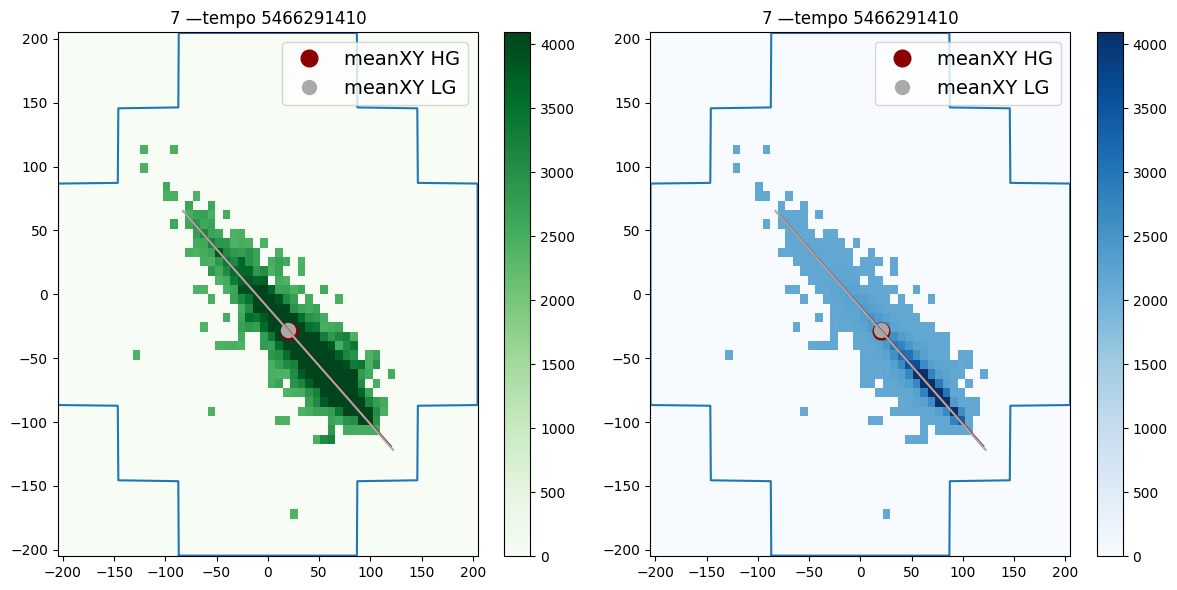

[[ 971.25234186  152.12897595]
 [ 152.12897595 3792.99210402]]


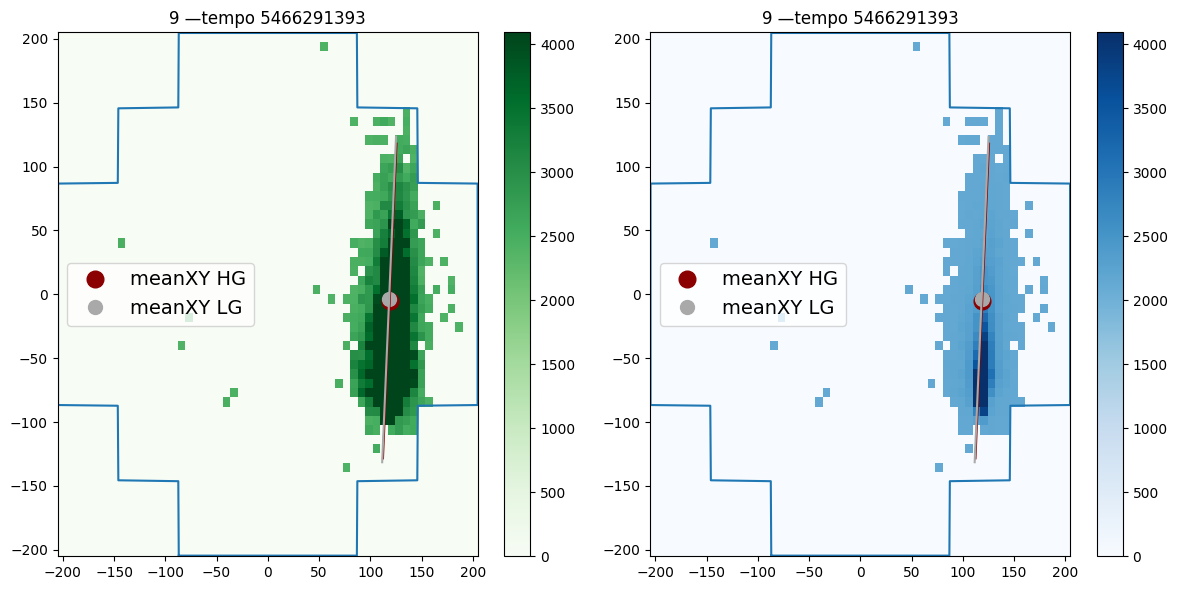

[[3289.80778825  702.93032784]
 [ 702.93032784 1007.57327936]]


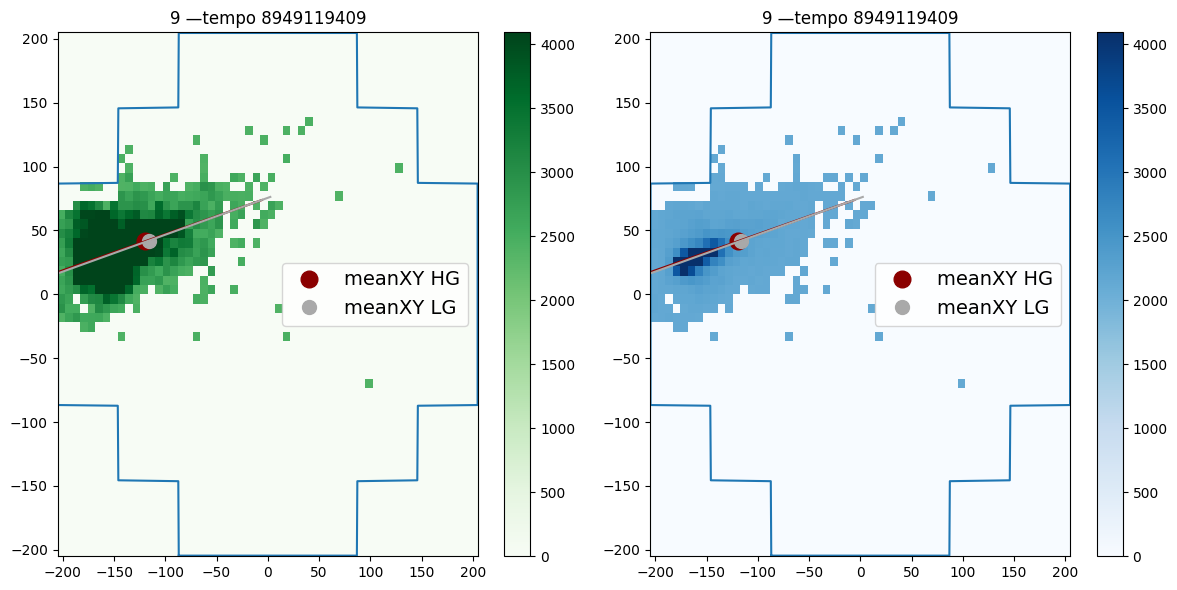

In [130]:
'''
studio dei centroidi e rette potrei fare un data frame: ogni evento con 
centroide e retta corrispondente

'''
top_indices = np.argsort(event_energies)[-3:]
#i 3 eventi più energetici in assoluto tra tutti i file
for iev in top_indices:
    #print(f"mc={df_all_sorted['MCRUN'][iev]}, ev={df_all_sorted['EVENT'][iev]}")
    
    # ciclo sui primi eventi piu energetici
    #for iev in range(10):
    hgev = np.array(df_all_sorted['HG'])[iev]
    lgev = np.array(df_all_sorted['LG'])[iev]
    ttpev = np.array(df_all_sorted['TTP'])[iev]
            # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)

            # sigma clipping per pulizia
            #hgev = stats.sigma_clip(hgev, sigma=4., cenfunc='mean').filled(0)
            #lgev = stats.sigma_clip(lgev, sigma=6., cenfunc='mean').filled(0)
            
            # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
   
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
            
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iev]} —tempo {df_all_sorted['TIME_ABS'][iev]}")
            #centroidi
            ai.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred',  label='meanXY HG')
            ai.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey', label='meanXY LG')
            #le rette
            ai.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
            ai.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')

            ai.legend(fontsize=14)
    plt.show()                     



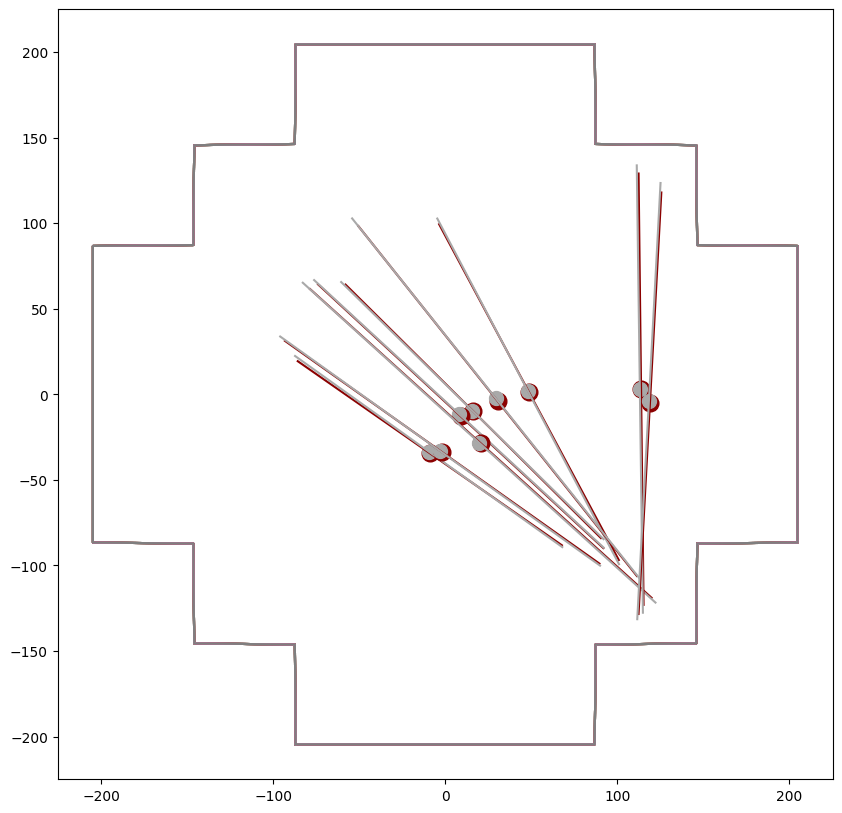

In [131]:
#studio di uno stesso evento
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)

for itel in range(9):

    hgev = np.array(df_target['HG'])[itel]
    lgev = np.array(df_target['LG'])[itel]
    ttpev = np.array(df_target['TTP'])[itel]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    ax.plot(xfp, yfp)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    ax.plot(xfp, yfp)
            #centroidi
    ax.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
    ax.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette
    ax.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
    ax.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
plt.show()

In [132]:
#definisco un dataframe con le differenze temporali giuste ordinate

dt = np.diff(df_all_sorted["TIME_ABS"])
logdt = np.log10(dt)

mask = (logdt > 2.8) & (logdt < 3.2)

df_dt = df_all_sorted.iloc[1:][mask]

'''
df_dt= df_all_sorted[
    ( np.log10(np.diff(df_all_sorted["TIME_ABS"])> 2.8) & 
    (np.log10(np.diff(df_all_sorted["TIME_ABS"]) < 3.2)))
]
'''

#sono tanti, prendo i più energetici
df_dt['shape']= df_dt['HG'].apply(np.sum).to_numpy()
df_dt.sort_values('shape',ascending=False, inplace=True)
df_dt.head()


/tmp/ipykernel_4476/3123814599.py:4: RuntimeWarning: divide by zero encountered in log10
  logdt = np.log10(dt)
/tmp/ipykernel_4476/3123814599.py:4: RuntimeWarning: invalid value encountered in log10
  logdt = np.log10(dt)


,TIME_NS,TIME_S,TIME_ABS,EVENT,MCRUN,TEL_ID,HG,LG,TTP,shape
7262,636313625,2,2636313625,304,263475,4,"[[2180, 2159, 2170, 2107, 2075, 2066, 2287, 22...","[[2131, 2129, 2130, 2127, 2125, 2125, 2136, 21...","[[255, 255, 255, 255, 255, 255, 119, 255, 255,...",5153697
7155,601210223,2,2601210223,7903,263470,4,"[[2170, 2127, 2190, 2152, 2135, 2231, 2118, 22...","[[2130, 2128, 2131, 2129, 2129, 2133, 2128, 21...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5152161
23750,694608470,8,8694608470,2217,266344,4,"[[2029, 2121, 2163, 2191, 2197, 2181, 2171, 22...","[[2123, 2128, 2130, 2131, 2131, 2131, 2130, 21...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5151216
25059,230173114,9,9230173114,9407,266391,4,"[[2224, 2115, 2243, 2208, 2088, 2185, 2102, 22...","[[2133, 2128, 2134, 2132, 2126, 2131, 2127, 21...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",5150067
14971,518340974,5,5518340974,7119,266039,9,"[[2141, 2106, 2144, 2173, 2204, 2317, 2180, 22...","[[2129, 2127, 2129, 2130, 2132, 2138, 2130, 21...","[[255, 255, 255, 255, 255, 133, 255, 255, 255,...",5149699


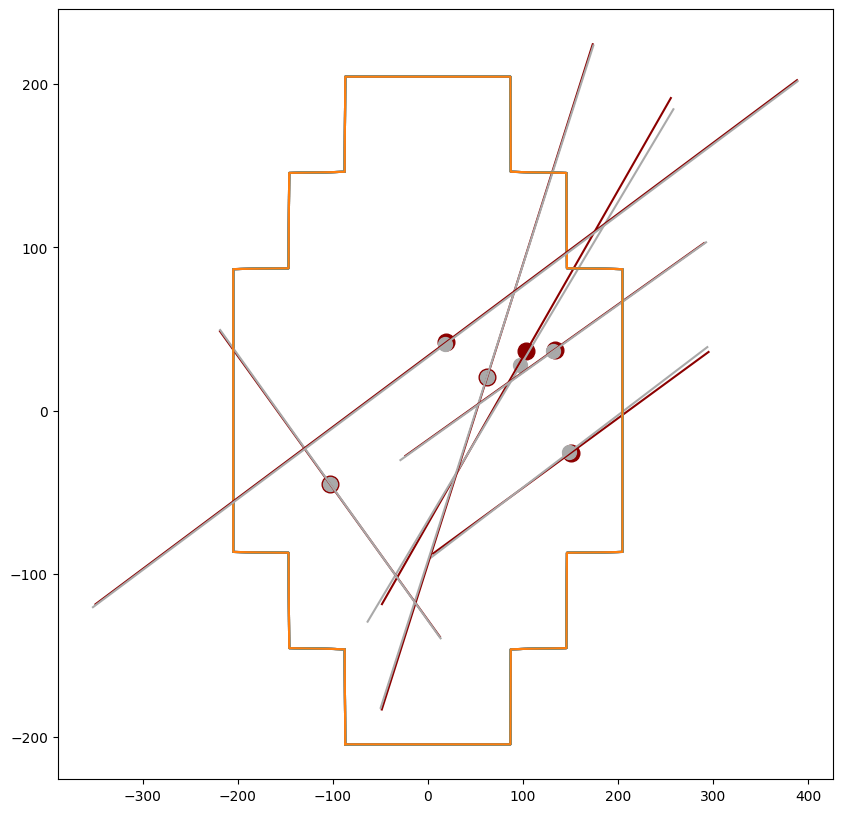

6
{'p0': array([150.48839762, -25.87493351]), 'd': array([0.91989747, 0.39215895]), 'tel': 8}


In [151]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)
rette=[]
for iv in range(6):

    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    ax.plot(xfp, yfp)
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel,
        #"tipo": "HG"-----------> per il momento solo hg
    })
    ax.plot(xfp, yfp)
            #centroidi
    ax.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
    ax.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette
    ax.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
    ax.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
plt.show()
print(len(rette))
print(rette[0])


In [143]:
#intersezione tra rette
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  # parallele → nessuna intersezione

    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
N = len(rette)
inters=[]
for i in range(N):
    p1=rette[i]["p0"]
    d1 = rette[i]["d"]
    for j in range(i+1, N):
        p2=rette[j]["p0"]
        d2 = rette[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters.append(P)
inters = np.array(inters)
valid_points = []
eps=8.#da definire
for i, p in enumerate(inters):
    # distanza p da tutte le altre
    d = np.sqrt(np.sum((inters - p)**2, axis=1))
    
    # quante intersezioni cadono entro il raggio
    n = np.sum(d < eps)
    
    # se abbastanza intersezioni vicine → salva
    if n >= 3:
        valid_points.append(p)

valid_points = np.array(valid_points)
print(valid_points)

[[ -34.69013864 -104.81788471]
 [ -30.99449061 -103.24240318]
 [ -32.19435313 -102.27128907]]


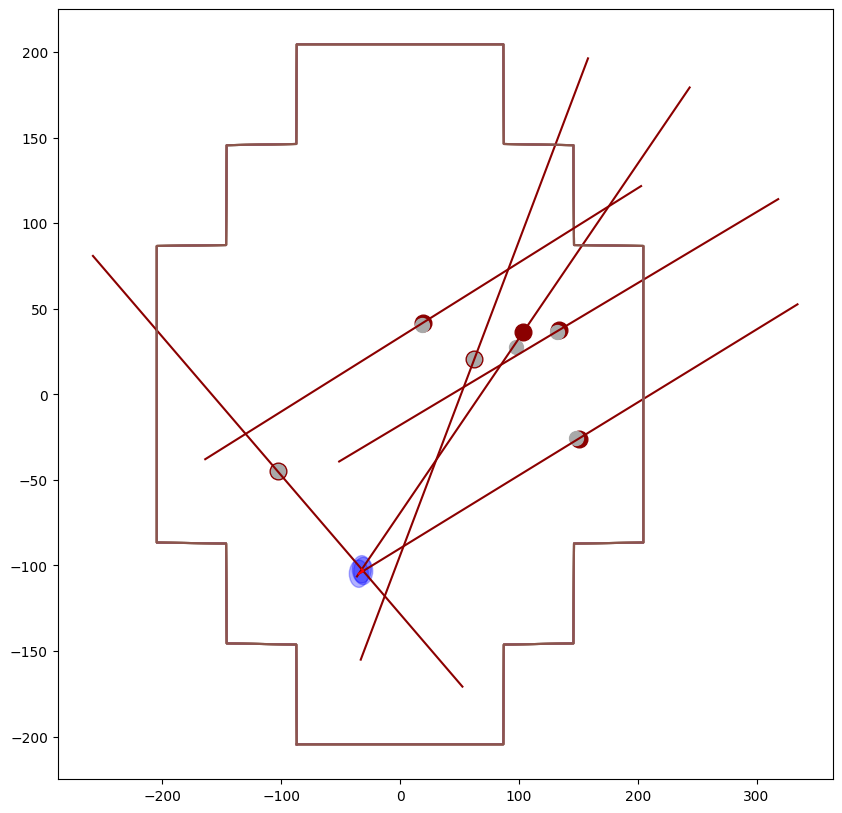

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xfp, yfp, 'k-', linewidth=1)

for iv in range(6):

    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
        #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "camera": itel,
        #"tipo": "HG"-----------> per il momento solo hg
    })
    ax.plot(xfp, yfp)
            #centroidi
    ax.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
    ax.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette-------------------
        #sistemazione grafica
    
    p = np.array([meanx_hg, meany_hg])
    d = np.array([np.cos(theta_hg), np.sin(theta_hg)])
    ##senza controlli per d[0]=0
    x = [p[0] - 200 * d[0], p[0] + 200 * d[0]]
    y = [p[1] - 200 * d[1], p[1] + 200 * d[1]]

    ax.plot(x, y, '-', color='darkred')
    '''
    ax.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
    ax.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
    '''
for x, y in valid_points:
    cerchio = plt.Circle((x, y), eps, color='blue', alpha=0.3, fill=True)
    ax.add_patch(cerchio)
ax.plot(valid_points[:,0], valid_points[:,1], 'red')

plt.show()